In [1]:
# https://www.kaggle.com/nkaps98/quora-question-pairs-glove-lstm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Multiply, Flatten, Dropout, Dense, LSTM
from sklearn.model_selection import train_test_split

df_train = pd.read_csv(
    "./fragen/train.csv",
    usecols = ['question1', 'question2', 'is_duplicate'],
    encoding = 'utf-8'
)

df_train.dropna(inplace=True)
df_train.drop_duplicates(inplace=True)
df_train.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Visualize the data
## Number of duplicate and non-duplicate questions

Text(0.5, 1.0, 'Number of elements found in dataset')

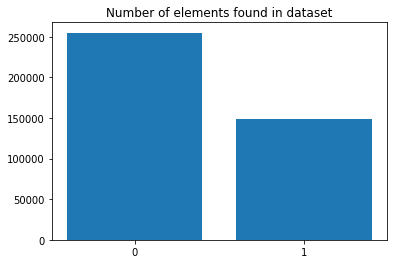

In [2]:
fig, ax = plt.subplots()

ax.bar([0,1],df_train.is_duplicate.value_counts())
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Number of elements found in dataset')

Es lässt sich beobachten, das circa 100k mehr Fragen mit dem Label 0, also sinnlich nicht verwandt, versehen sind. Dies kann bei dem trainierten Modell dazu führen, dass das Model zuverlässiger bei der Erkennung von nicht gleichen Fragen als bei gleichen Fragen ist.

In [3]:
tf.random.set_seed(35)

target = df_train.pop('is_duplicate')

xTrain, xValid, yTrain, yValid = train_test_split(df_train, target, test_size=0.2, random_state=35)
xTrain.head()

,question1,question2
283108,Which are the best German universities for an ...,Which are the best German universities for an ...
73636,I like being merchant navy?,Are astronauts allowed to masturbate in space?
46418,What is the legal definition of a human being?...,What do men think about menstrual cycle?
11449,How can I handle having personal issues with m...,How do I take things my partner says less pers...
283432,"How cold can the Gobi Desert get, and how do i...","How cold can the Gobi Desert get, and how do i..."


# Create tokenizer

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_train.question1.values) + list(df_train.question2.values))

# Encode and pad the questions

In [5]:
def tokenizeQuestions(df_questions):
    tokenized_questions = tokenizer.texts_to_sequences(df_questions)
    return pad_sequences(tokenized_questions, maxlen = 40, padding = 'post')

In [45]:
print(type(xValid.question1))

<class 'pandas.core.series.Series'>


In [40]:
q1_train = tokenizeQuestions(xTrain.question1)
q2_train = tokenizeQuestions(xTrain.question2)

q1_valid = tokenizeQuestions(xValid.question1)
q2_valid = tokenizeQuestions(xValid.question2)


[ 23  11   1  18 922 417  14  32 524   8 356 128  14 528   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [8]:
dict = tokenizer.word_index

# Create the first model for one question

In [18]:
q1_model = tf.keras.Sequential()
q1_model.add(Embedding(len(dict)+2, output_dim = 200, input_length = 40))
q1_model.add(LSTM(128, return_sequences = True))
q1_model.add(Dense(2))
q1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 200)           19119400  
                                                                 
 lstm_2 (LSTM)               (None, 40, 128)           168448    
                                                                 
 dense_5 (Dense)             (None, 40, 2)             258       
                                                                 
Total params: 19,288,106
Trainable params: 19,288,106
Non-trainable params: 0
_________________________________________________________________


# Create the second model for the second question

In [19]:
q2_model = tf.keras.Sequential()
q2_model.add(Embedding(len(dict)+2, output_dim = 200, input_length = 40))
q2_model.add(LSTM(128, return_sequences = True))
q2_model.add(Dense(2))
q2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 200)           19119400  
                                                                 
 lstm_3 (LSTM)               (None, 40, 128)           168448    
                                                                 
 dense_6 (Dense)             (None, 40, 2)             258       
                                                                 
Total params: 19,288,106
Trainable params: 19,288,106
Non-trainable params: 0
_________________________________________________________________


# Merging the input of the two models

In [20]:
mergedOut = Multiply()([q1_model.output, q2_model.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(1, activation = 'sigmoid')(mergedOut)

# Create the model

In [21]:
model = tf.keras.Model(inputs = [q1_model.input, q2_model.input], outputs = mergedOut)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_2_input (InputLayer)  [(None, 40)]        0           []                               
                                                                                                  
 embedding_3_input (InputLayer)  [(None, 40)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 40, 200)      19119400    ['embedding_2_input[0][0]']      
                                                                                                  
 embedding_3 (Embedding)        (None, 40, 200)      19119400    ['embedding_3_input[0][0]']      
                                                                                            

# Compile and fit the model

In [22]:

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 5,
                    batch_size = 1000
)

Epoch 1/5
  1/324 [..............................] - ETA: 20:06 - loss: 0.6932 - accuracy: 0.3760

2022-03-03 12:46:19.132736: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


324/324 [==============================] - 28s 74ms/step - loss: 0.5273 - accuracy: 0.7337 - val_loss: 0.4749 - val_accuracy: 0.7693
Epoch 2/5
324/324 [==============================] - 23s 72ms/step - loss: 0.4295 - accuracy: 0.7967 - val_loss: 0.4624 - val_accuracy: 0.7796
Epoch 3/5
324/324 [==============================] - 24s 73ms/step - loss: 0.3587 - accuracy: 0.8348 - val_loss: 0.4885 - val_accuracy: 0.7791
Epoch 4/5
324/324 [==============================] - 24s 73ms/step - loss: 0.3007 - accuracy: 0.8642 - val_loss: 0.5183 - val_accuracy: 0.7774
Epoch 5/5
324/324 [==============================] - 24s 73ms/step - loss: 0.2555 - accuracy: 0.8862 - val_loss: 0.6505 - val_accuracy: 0.7694


In [76]:
def getPrediction(question1, question2):
    test1 = tokenizer.texts_to_sequences(list([question1]))
    test1 = pad_sequences(test1, maxlen = 40, padding = 'post')
    test2 = tokenizer.texts_to_sequences(list([question2]))
    test2 = pad_sequences(test2, maxlen = 40, padding = 'post')
    return 1 if model.predict([test1, test2]) / 1 >= 0.5 else 0


In [78]:
getPrediction("What was your first sexual experience like?", "What was?")

0